# Hanno Rein
# Orbital Dynamics with REBOUND
# 

In [1]:
%matplotlib inline
from numpy import sqrt
from rebound import Simulation, SimulationArchive, OrbitPlot

## Outline
1. High order integrators
2. Tips and tricks
3. Variational equations

# REBOUND
- N-body integrator package
- Planetary systems
- Collisional simulations of planetary rings
- Many different built-in integrators
- Written in C with python interface

## 1. High order integrators
- Different approaches
  - Brute force (BS, Everhart)
  - Composition methods (Yoshida)
  - Hamiltonian system (Wisdom, Blanes, EOS)
- A large variety implemented in REBOUND
- Easy to use

## IAS15
- Rein & Spiegel (2015), based on Everhart (1985)
- General purpose 15th order ODE solver
- adaptive timestepping
- arbitrary forces, arbitrary hierarchies

In [2]:
sim = Simulation()
sim.integrator

'ias15'

## Timesteps for high order integrator
- IAS15 is adaptive - no need to set it manually
- Small range of timesteps that makes sense
- Need to resolve orbital period:  $\,dt\lesssim0.1P$
- Reducing $dt$ by 10 reduces error by $10^{15}$ (~machine precision)
- Thus: 
$\,0.01P\lesssim dt\lesssim0.1P$
- 4th order integrator (RK4) does not make sense
- 30th order integrator does not make sense

In [3]:
sim.ri_ias15.epsilon = 1e-3 # don't do this.

## Integrators and Hamiltonian system 
- Make use of additional structure in the ODEs (second order ODE, conservative, symplectic)
- Leap-frog integrator
$$O\left(dt^2\right)$$
- Wisdom-Holman integrator
$$O\left(\epsilon \,dt^2\right)$$

Can do better than that!
- SABA(10,6,4), Blanes et al. 2013
$$O\left(\epsilon\, dt^{10} + \epsilon^2 \,dt^6 + \epsilon^3 \,dt^4\right)$$
- Symplectic correctors, Wisdom et al. 1996
$$O\left(\epsilon\, dt^{18} + \epsilon^2\, dt^2\right)$$
- WHCKL, Wisdom et al. 1996
$$O\left(\epsilon \,dt^{18} + \epsilon^2\, dt^4 + \epsilon^3 \,dt^3\right)$$

In [4]:
sim.integrator = "SABA(10,6,4)"
sim.integrator = "WHC"
sim.integrator = "WHCKL"

<img src="highorder.png">

**High order symplectic integrators for planetary dynamics and their implementation in REBOUND** <br/>
Hanno Rein, Daniel Tamayo, Garett Brown<br/>
MNRAS Volume 489, Issue 4, November 2019, Pages 4632–4640

# 2. Tips and tricks

### Adding particles

In [5]:
sim = Simulation()

In [6]:
sim.add(["Sun", "Earth", "SpaceX Roadster"])

Searching NASA Horizons for 'Sun'... Found: Sun (10).
Searching NASA Horizons for 'Earth'... Found: Earth-Moon Barycenter (3).
Searching NASA Horizons for 'SpaceX Roadster'... Found: SpaceX Roadster (spacecraft) (-1.


/Users/hannorein/git/rebound/rebound/horizons.py:140: RuntimeWarning: Warning: Mass cannot be retrieved from NASA HORIZONS. Set to 0.
  warnings.warn("Warning: Mass cannot be retrieved from NASA HORIZONS. Set to 0.", RuntimeWarning)


In [7]:
sim.add(m=1e-6, x=2, vy=0.7) 

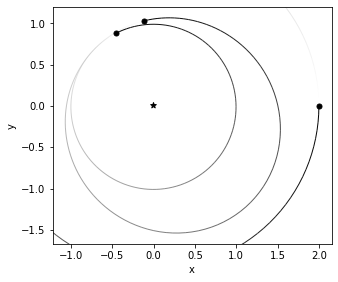

In [8]:
OrbitPlot(sim);

In [9]:
#sim.add("Moon")
earth = sim.particles[1]
sim.add(m=3.7e-8, a=0.0025, e=0.01, omega=0.01, primary=earth)

In [10]:
spacecraft = earth.copy()
spacecraft.m = 0
earth_r = 4.2e-5 # Earth radius in AU
spacecraft.x += earth_r
spacecraft.vx += sqrt(2.*sim.G*earth.m/earth_r)
sim.add(spacecraft)

### Saving, loading, copying simulations

In [11]:
sim.save("talkbackup.bin") # Save
sim = Simulation("talkbackup.bin") # Load

In [12]:
sim0 = sim.copy()
sim0 == sim

True

In [13]:
sim.step()
sim0 == sim

False

In [14]:
diff = sim - sim0
diff.particles[1].xyz

[-3.7376693777235737e-06, -1.9284244517914217e-06, 1.5232460724625557e-10]

 ### SimulationArchive
- No need to think about what to output
- Take snapshots, then compute outputs later

In [15]:
sim.automateSimulationArchive("archive.bin", interval=10, deletefile=True)
sim.integrate(100)

In [16]:
sa = SimulationArchive("archive.bin")
len(sa)

10

In [17]:
sim = sa[5]
print(sim.particles[1].e)
sim.integrate(7)
print(sim.particles[1].e)

0.015617710287655713
0.0159986189797199


# 3. Variational Equations
- Derivatives with respect to the initial conditions
- TTV, Hamiltonian MCMC, ML, ...
- Lyapunov exponents, MEGNO
- 1st and 2nd order implemented in REBOUND
- Implemented by hand, no auto-diff
- Variational maps are also symplectic maps

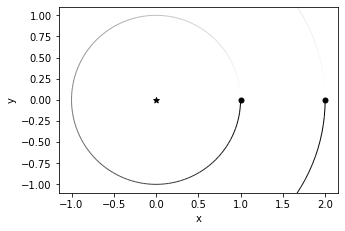

In [18]:
sim = Simulation()
sim.add(m=1)
sim.add(m=1e-3, a=1)
sim.add(m=1e-3, a=2)
OrbitPlot(sim);

In [19]:
var_a = sim.add_variation()
var_a.vary(2, "a")

In [20]:
print(var_a.particles[1].x)
sim.integrate(10)
print(var_a.particles[1].x)

0.0
-0.01737668985525693


$$x_1(a_2 + \delta a_2) =\\ x_1(a_2) + \delta a_2 \cdot \underbrace{\left.\frac{\partial x_1}{\partial a_2} \right|_{\delta a_2=0}}   +\, \delta a^2_2 \cdot \left.\frac{\partial^2 x_1}{\partial a^2_2} \right|_{\delta a_2=0} + \ldots$$

**Second-order variational equations for N-body simulations** <br />
Hanno Rein, Daniel Tamayo<br />
MNRAS Volume 459, Issue 3, p.2275-2285

# Thank you!
# github&#46;com/hannorein/rebound